In [3]:
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
from sklearn.cluster import AgglomerativeClustering as HAC
import matplotlib.cm as cm
from cycler import cycler
import pandas as pd
import requests
import io
from matplotlib.lines import Line2D

plt.rcParams.update({'font.size':16})

In [6]:
#read in data from github
def remote_get(url):
  ro = requests.get(url) 
  if ro.ok:
    data = np.load(io.BytesIO(ro.content))
    return data 
  else:
    print('failed to retrieve file')
    
  
# Data = remote_get('https://github.com/evanphoward/cs242-final/blob/main/cifar_input_values.npy?raw=true')  #set of data vectors (inputs to FC layer)
# b = remote_get('https://github.com/evanphoward/cs242-final/blob/main/cifar_classifier_weights.npy?raw=true') #weights of FC layer

# The following files must be loaded into the notebook directory
# so they can be loaded with numpy.  
Data_cifar = np.load('cifar_input_values.npy')
B_cifar = np.load('cifar_classifier_weights.npy').T

Data_mnist = np.load('mnist_input_values.npy')
B_mnist = np.load('mnist_classifier_weights.npy').T

# for k in Data.keys():
#  print(k)
# for l in b.keys():
#  print(k)

In [8]:

### only needed if you need to make fake data 
#make set of fake data which is a set of multi-variate Gaussians
def make_data():
  ndim = 256
  n_centers = 10
  n_samples = int(15000/n_centers)
  bxsz = 1
  n_weights = 10 

  MU = []
  mu = (np.random.rand(ndim) - 0.5*np.ones((ndim))) * bxsz
  temp  = np.random.rand(ndim,ndim)
  e_val, e_vec = np.linalg.eig(temp.T @ temp)
  cov = e_vec @ np.diag(np.abs(np.random.randn(ndim)*4)) @ e_vec.T
  Data = np.random.multivariate_normal(mu, cov, size=n_samples)
  MU.append(mu)
  for mu in range(n_centers-1):
      mu = (np.random.rand(ndim) - 0.5*np.ones((ndim))) * bxsz
      temp  = np.random.rand(ndim,ndim)
      e_val, e_vec = np.linalg.eig(temp.T @ temp)
      cov = e_vec @ np.diag(np.abs(np.random.randn(ndim)*4)) @ e_vec.T
      Data = np.concatenate((Data, np.random.multivariate_normal(mu, cov, size=n_samples)), axis=0)
      MU.append(mu)

  MU = np.array(MU)

  #make fake weight values
  B = np.random.rand(ndim,n_weights)
  return Data, B

Data_fake, B_fake = make_data() 

In [ ]:
# calculate the centroids using clustering (but where this is done in each subspace)
def get_centroids(Data,b,n_sub=5,n_cen=5):
  # Data: n_samples x n_dim matrix of vectors
  # b : n_dim x n_weights matrix of fixed weights
  # n_sub:  number of subspaces
  # n_cen: number of centroids 
  n_dim = Data.shape[1]
  n_samples = Data.shape[0]
  n_weights = b.shape[1]
  Data_approx = np.zeros_like(Data)
  Centroids = []
  r = n_dim % n_sub

  subspace_idx_pairs = []
  i=0
  for idx in range(n_sub):
      irange = n_dim//n_sub + bool(idx<r)
      subspace_idx_pairs.append((i,i+irange))
      i = i+irange
      
  covariances = []
  Labels = []
  for i1,i2 in subspace_idx_pairs:
      kmeans = KMeans(n_clusters=n_cen).fit(Data[:,i1:i2])
      Centroids.append(kmeans.cluster_centers_)
      Labels.append(kmeans.labels_)
      
      #subspace_cov = []
      Data_approx[:,i1:i2] = kmeans.cluster_centers_[kmeans.labels_,:]
      #for label in np.unique(kmeans.labels_):
          #mask = kmeans.labels_ == label
          #X = Data[mask,i1:i2] - Data[mask,i1:i2].mean(axis=0).reshape(1,-1)
          #subspace_cov.append( X.T @ X /(np.sum(mask)-1))
      
      #covariances.append(subspace_cov)

  Labels = np.array(Labels)
  return Data_approx, Centroids, Labels, covariances, subspace_idx_pairs

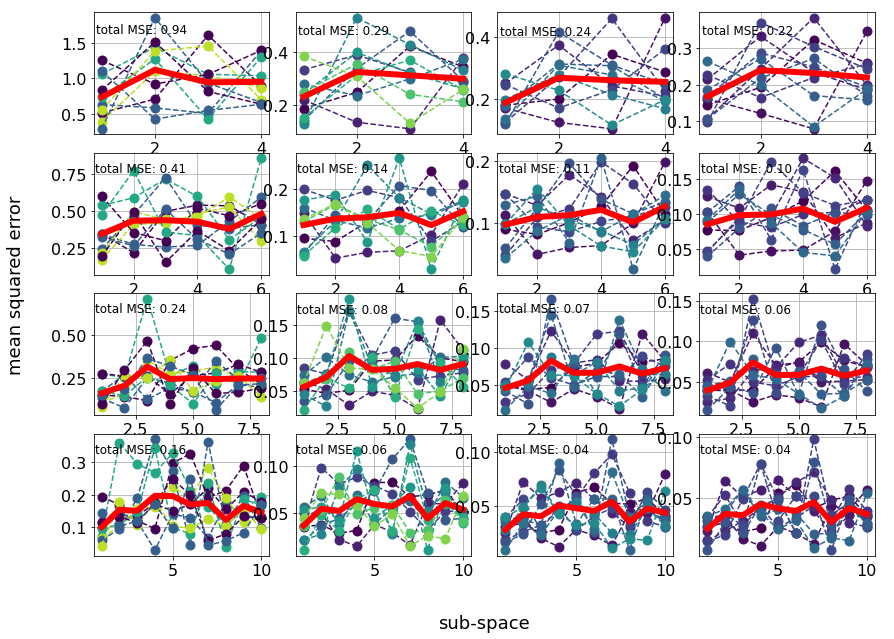

In [ ]:
#  ANTIQUATED (should still run though)
# function to plot the MSEs in each subspace for each K-Means cluster
def plot_mse(ax,Error,Labels):
  n_sub = Error.shape[2]
  n_weights = Error.shape[0]
  n_cen = len(np.unique(Labels[0]))
  cmap = cm.get_cmap('viridis')
  custom_cycler = cycler(color=cmap(np.linspace(0,0.9,n_weights))) 
  ax.set_prop_cycle(custom_cycler)

  error2 = np.zeros((n_sub,n_weights))
  for subspc in range(n_sub):
      for w in range(n_weights):
          error2[subspc,w] = np.mean(Error[w,:,subspc]**2)
  
  total_mse = np.mean(Error**2)
  
  ax.plot(np.arange(1,n_sub+1), error2, '.--', ms=18)
  ax.plot(np.arange(1,n_sub+1), np.mean(error2,axis=1),'r',lw=6)
  #ax.set(xticks=np.arange(1,n_cen+1), xlabel='subspace' ,ylabel=r'mean squarred error')
  ax.text(ax.get_xlim()[0]+0.05, ax.get_ylim()[1]*0.85, 'total MSE: {:.2f}'.format(total_mse), fontsize=12)
  ax.grid()

  return total_mse


#try out different parameter values for n_sub and n_cen
n_samples = Data_mnist.shape[0]
n_weights = B_mnist.shape[1]
sbspcs = 4
centrds = 4
fig,ax = plt.subplots(sbspcs, centrds, figsize=(14,10),gridspec_kw={'hspace':0.15,'wspace':0.15})
bigInvisibleAx = fig.add_subplot(111,frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
bigInvisibleAx.set_ylabel('mean squared error', fontsize=18, labelpad=36)
bigInvisibleAx.set_xlabel('sub-space', fontsize=18, labelpad=36)

for row, n_sub in enumerate(np.linspace(4,10,sbspcs,dtype=int)):
  for col, n_cen in enumerate(np.linspace(4,25,centrds,dtype=int)):
    Data_approx, Centroids, Labels, covariances, subspace_idx_pairs = get_centroids(Data_mnist, B_mnist, n_sub=n_sub, n_cen=n_cen)

    # calculate the error of the approximation compared to the real values  
    Error = np.zeros((n_weights, n_samples,n_sub))
    for idx,(i1,i2) in enumerate(subspace_idx_pairs):
      Error[:,:,idx] = (Data_approx[:,i1:i2] @ B_mnist[i1:i2,:] - Data_mnist[:,i1:i2] @ B_mnist[i1:i2,:]).T 

    plot_mse(ax[row,col], Error, Labels)

In [ ]:
#get mse
def get_error(Data, b, n_sub=5, n_cen=5):
  n_dim = Data.shape[1]
  Data_approx = np.zeros_like(Data)
  r = n_dim % n_sub

  i = 0
  for idx in range(n_sub):
      irange = n_dim//n_sub + bool(idx<r)
      kmeans = KMeans(n_clusters=n_cen).fit(Data[:,i:i+irange])
      Data_approx[:,i:i+irange] = kmeans.cluster_centers_[kmeans.labels_,:]
      i = i+irange

  return np.mean((Data_approx @ b - Data @ b)**2) #total mse
 
sbspcs = np.linspace(3,18,4,dtype=int)
cntrds = np.linspace(4,30,14,dtype=int)
mse_mnist = np.zeros((len(cntrds), len(sbspcs)))
mse_cifar = np.zeros((len(cntrds), len(sbspcs)))
for row, n_cen in enumerate(cntrds):
  for col, n_sub in enumerate(sbspcs):
    mse_mnist[row,col] = get_error(Data_mnist, B_mnist, n_sub=n_sub, n_cen=n_cen)
    mse_cifar[row,col] = get_error(Data_cifar, B_cifar, n_sub=n_sub, n_cen=n_cen)

In [ ]:
np.save('mse_mnist.npy',mse_mnist)
np.save('mse_cifar.npy', mse_cifar)

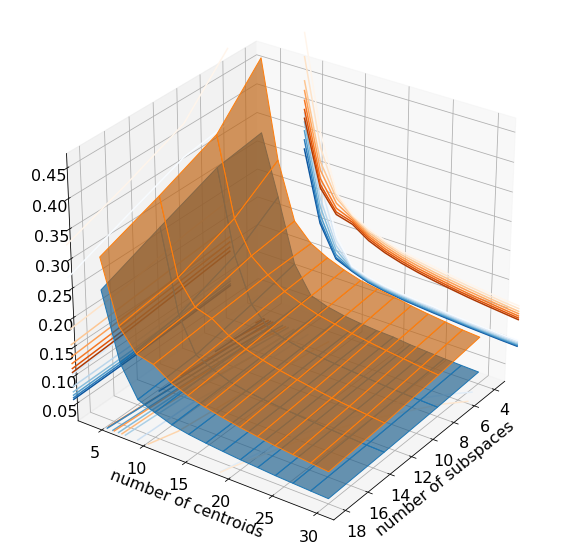

In [ ]:
#%matplotlib inline
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')
ax.view_init(elev=30, azim=35)
X, Y = np.meshgrid(sbspcs, cntrds)
CS = ax.plot_surface(X, Y, mse_mnist, edgecolor='tab:blue', label='mnist', alpha=0.65)
ax.contour(X,Y, mse_mnist, zdir='z', offset=0, cmap='Blues')
ax.contour(X,Y, mse_mnist, zdir='x', offset=0, cmap='Blues')
ax.contour(X,Y, mse_mnist, zdir='y', offset=0, cmap='Blues')
CS2 = ax.plot_surface(X,Y, mse_cifar, edgecolor='tab:orange', label='cifar', alpha=0.65)
ax.contour(X,Y, mse_cifar, zdir='z', offset=0, cmap='Oranges')
ax.contour(X,Y, mse_cifar, zdir='x', offset=0, cmap='Oranges')
ax.contour(X,Y, mse_cifar, zdir='y', offset=0, cmap='Oranges')
#ax.legend()
#ax.clabel(CS, inline=True)
ax.set(xlabel='number of subspaces', ylabel="number of centroids")

plt.show()

In [ ]:
#get model accuracy
def get_acc(Data, b, targets, n_sub=5, n_cen=5):
  n_dim = Data.shape[1]
  Data_approx = np.zeros_like(Data)
  r = n_dim % n_sub

  i = 0
  for idx in range(n_sub):
      irange = n_dim//n_sub + bool(idx<r)
      kmeans = KMeans(n_clusters=n_cen).fit(Data[:,i:i+irange])
      Data_approx[:,i:i+irange] = kmeans.cluster_centers_[kmeans.labels_,:]
      i = i+irange

  return  (np.argmax(Data_approx @ b, axis=1)==targets).sum() / len(targets)

#asses model accuracy
targets_cifar = np.load('cifar_ground_labels_test.npy')
Data_cifar_test = np.load('cifar_input_values_test.npy')

targets_mnist = np.load('mnist_ground_labels_test.npy')
Data_mnist_test = np.load('mnist_input_values_test.npy')

acc_mnist = np.zeros((len(cntrds), len(sbspcs)))
acc_cifar = np.zeros((len(cntrds), len(sbspcs)))
sbspcs = np.linspace(3,18,4,dtype=int)
cntrds = np.linspace(4,30,14,dtype=int)
for row, n_cen in enumerate(cntrds):
  for col, n_sub in enumerate(sbspcs):
    acc_mnist[row,col] = get_acc(Data_mnist_test, B_mnist, targets_mnist, n_sub=n_sub, n_cen=n_cen)
    acc_cifar[row,col] = get_acc(Data_cifar_test, B_cifar, targets_cifar, n_sub=n_sub, n_cen=n_cen)

np.save('acc_mnist.npy', acc_mnist)
np.save('acc_cifar.npy', acc_cifar)

In [ ]:
sbspcs = np.linspace(4,18,4,dtype=int)
cntrds = np.linspace(4,30,14,dtype=int)
acc_mnist_orig = (np.argmax(Data_mnist_test @ B_mnist, axis=1)==targets_mnist).sum() / len(targets_mnist)
acc_cifar_orig = (np.argmax(Data_cifar_test @ B_cifar, axis=1)==targets_cifar).sum() / len(targets_cifar)
print(acc_mnist_orig, acc_cifar_orig)

0.9884 0.929


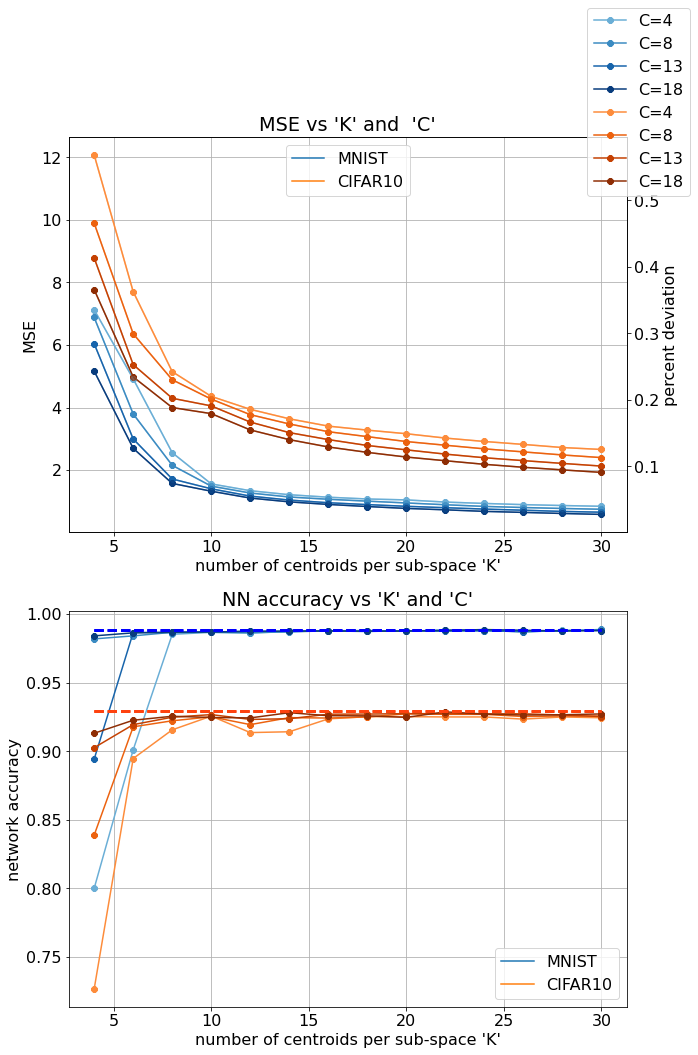

In [ ]:
mse_mnist = np.load('mse_mnist.npy') 
mse_cifar = np.load('mse_cifar.npy') 
acc_mnist = np.load('acc_mnist.npy')
acc_cifar = np.load('acc_cifar.npy')

fig, ax = plt.subplots(2,1, figsize=(10,16))
cmap_bl = cm.get_cmap('Blues')
cmap_or = cm.get_cmap('Oranges')
for col in range(mse_mnist.shape[1]):
  ax[0].plot(cntrds, mse_mnist[:,col], '8-',c=cmap_bl(col/mse_mnist.shape[1]*0.6+0.5), label='C={:d}'.format(sbspcs[col]))
  ax[1].plot(cntrds, acc_mnist[:,col], '8-',c=cmap_bl(col/mse_mnist.shape[1]*0.6+0.5), label='C={:d}'.format(sbspcs[col]))

for col in range(mse_cifar.shape[1]):
  ax[0].plot(cntrds, mse_cifar[:,col], '8-',c=cmap_or(col/mse_cifar.shape[1]*0.6+0.5), label='C={:d}'.format(sbspcs[col]))
  ax[1].plot(cntrds, acc_cifar[:,col], '8-',c=cmap_or(col/mse_cifar.shape[1]*0.6+0.5), label='C={:d}'.format(sbspcs[col]))

#put original model accuracies as dotted lines
ax[1].plot(cntrds, acc_mnist_orig*np.ones_like(acc_mnist),'--', c='b', lw=2.5)
ax[1].plot(cntrds, acc_cifar_orig*np.ones_like(acc_cifar),'--', c='xkcd:orangered', lw=2.5)

h, l = ax[0].get_legend_handles_labels()
fig.legend(h,l)
ax[0].set(xlabel='number of centroids per sub-space \'K\'', ylabel='MSE', title='MSE vs \'K\' and  \'C\'')
ax[1].set(xlabel='number of centroids per sub-space \'K\'', ylabel='network accuracy', title='NN accuracy vs \'K\' and \'C\'')
ax[0].legend([Line2D([0],[0],color='tab:blue'), Line2D([0],[0],color='tab:orange')], ['MNIST', 'CIFAR10'], loc='upper center')
ax[1].legend([Line2D([0],[0],color='tab:blue'), Line2D([0],[0],color='tab:orange')], ['MNIST', 'CIFAR10'])
ax[0].grid()
ax[1].grid()

axtwin = ax[0].twinx()
axtwin.set_ylabel('percent deviation')
#axtwin.set_ylim([0.0056102, 0.486145])
#axtwin.set_yticklabels([0,0.1,0.2,0.3,0.4,0.5])
n1 = np.mean((Data_mnist@B_mnist)**2)
n2 = np.mean((Data_mnist@B_mnist)**2)
for col in range(mse_mnist.shape[1]):
  axtwin.plot(cntrds, mse_mnist[:,col]/n1, '8-',c=cmap_bl(col/mse_mnist.shape[1]*0.6+0.5), label='C={:d}'.format(sbspcs[col]),alpha=0.4)
  axtwin.plot(cntrds, mse_cifar[:,col]/n2, '8-',c=cmap_or(col/mse_cifar.shape[1]*0.6+0.5), label='C={:d}'.format(sbspcs[col]),alpha=0.4)
#axtwin.set_xticklabels()

In [ ]:
fig.savefig('mse_acc_rel.png',bbox_inches='tight')

In [9]:
MNIST_cov = Data_mnist.T @ Data_mnist / (Data_mnist.shape[1]-1)
CIFAR_cov = Data_cifar.T @ Data_cifar / (Data_cifar.shape[1]-1)
Fake_cov = Data_fake.T @ Data_fake / (Data_fake.shape[1]-1)
mnist_eval,_ = np.linalg.eig(MNIST_cov)
cifar_eval,_ = np.linalg.eig(CIFAR_cov)
fake_eval,_ = np.linalg.eig(Fake_cov)

In [11]:
mnist_min_err = np.trace(B_mnist.T @ MNIST_cov @ B_mnist) / B_mnist.shape[1] 
cifar_min_err = np.trace(B_cifar.T @ CIFAR_cov @ B_cifar) / B_cifar.shape[1]
fake_min_err = np.trace(B_fake.T @ Fake_cov @ B_fake) / B_fake.shape[1]
print(mnist_min_err/(Data_mnist.shape[0]))
print(cifar_min_err/(Data_cifar.shape[0]))
print(fake_min_err/(Data_fake.shape[0]))


0.08333612630208333
0.10195177734375001
0.9483629731326746
